In [289]:
import matplotlib as mlt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as scp
import scipy.stats as stats

from matplotlib.ticker import MultipleLocator, AutoMinorLocator


## Тестируемые квадратичные функции


In [181]:
def f_1(x):
    return x @ np.array(np.mat('2 0; 1 1')) @ x.T

def f_1_grad(x):
    a = np.array(np.mat('2 0; 1 1'))
    return (a + a.T) @ x.T

In [182]:
def f_2(x):
    return x @ np.array(np.mat('130 -70; 0.33 -0.01')) @ x.T

def f_2_grad(x):
    a = np.array(np.mat('130 -70; 0.33 -0.01'))
    return (a + a.T) @ x.T


## Сервисные функции

### Фабрика функций $\varphi(t) = f(x - t \cdot d)$


In [3]:
def phi_factory(func, x, d):
    return lambda t: func(x - t * d)


### Функция поиска минимума методом золотого сечения


In [73]:
def golden_method(func):
    right = -1
    left = 1
    eps = 0.00001
    phi = (1 + np.sqrt(5)) / 2
    resphi = 2 - phi
    x1 = left + resphi * (right - left)
    x2 = right - resphi * (right - left)
    f1 = func(x1)
    f2 = func(x2)
    while abs(right - left) > eps:
        if f1 < f2:
            right = x2
            x2 = x1
            f2 = f1
            x1 = left + resphi * (right - left)
            f1 = func(x1)
        else:
            left = x1
            x1 = x2
            f1 = f2
            x2 = right - resphi * (right - left)
            f2 = func(x2)
    return (x1 + x2) / 2


### Настройка 3D


In [373]:
def setup_3d_data(func, num):
    x = y = np.linspace(-1.5, 1.5, num=num)
    x = np.repeat(x, num)
    y = np.tile(y, num)
    z = []
    for i in range(num**2):
        z.append(func(np.array([x[i], y[i]])))
    x = np.reshape(x, (num, num))
    y = np.reshape(y, (num, num))
    z = np.reshape(z, (num, num))
    return x, y, z


## Метод наискорейшего спуска


In [74]:
def steepest_descent(func, grad, x_0, eps1, eps2, max_iter):
    x = x_0
    k = 0
    df = pd.DataFrame({"x": []})
    df.index.name = "i"
    df.name = "x"
    df.loc[len(df)] = [x]
    while True:
        grad_x = grad(x)
        if np.linalg.norm(grad_x) < eps1 or k >= max_iter:
            return x, k, df
        phi = phi_factory(func, x, grad_x)
        t = golden_method(phi)
        x_next = x - t * grad_x
        df.loc[len(df)] = [x_next]
        k += 1
        if np.linalg.norm(x_next - x) < eps2 and abs(func(x_next) - func(x)) < eps2:
            return x_next, k, df
        x = x_next


### Тест

#### $f_1(x)$

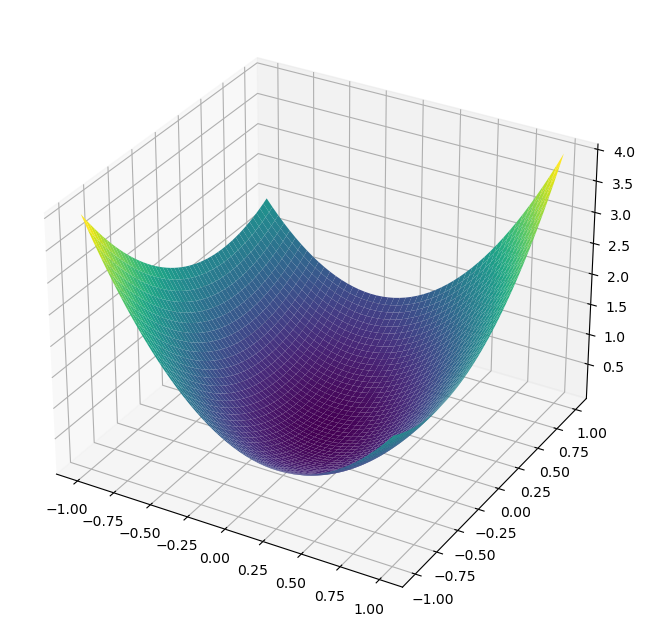

In [359]:
x2 = y2 = np.linspace(-1, 1)
x2 = np.repeat(x2, 50)
y2 = np.tile(y2, 50)
z2 = []
for i in range(2500):
    z2.append(f_1(np.array([x2[i], y2[i]])))
x2 = np.reshape(x2, (50, 50))
y2 = np.reshape(y2, (50, 50))
z2 = np.reshape(z2, (50, 50))
ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')
ax.plot_surface(x2, y2, z2, cmap=plt.cm.viridis, antialiased=True)


#### $f_2(x)$



## Метод сопряженных градиентов


In [164]:
def conjugate_gradient(func, grad, x_0, eps1, eps2, max_iter):
    x = x_prev = x_0
    k = 0
    prev_good = False
    df = pd.DataFrame({"x": []})
    df.index.name = "i"
    df.name = "x"
    df.loc[len(df)] = [x]
    while True:
        grad_x = grad(x)
        if np.linalg.norm(grad_x) < eps1 or k >= max_iter:
            return x, k, df
        if k == 0:
            d = - grad(x_0)
        else:
            beta = (np.linalg.norm(grad_x))**2 / (np.linalg.norm(grad(x_prev)))**2
            d = -grad_x + beta * d
        phi = phi_factory(func, x, -d)
        t = golden_method(phi)
        x_next = x + t * d
        df.loc[len(df)] = [x_next]
        k += 1
        if np.linalg.norm(x_next - x) < eps2 and abs(func(x_next) - func(x)) < eps2:
            if prev_good:
                return x_next, k, df
            prev_good = True
        else:
            prev_good = False
        x_prev = x
        x = x_next


## Генератор функций


In [77]:
def f_gen(n, k):
    u, _ = np.linalg.qr(np.random.randn(n, n))
    d = np.diag(np.linspace(1, k, n))
    a = u @ d @ u.T
    return lambda x: x @ a @ x.T, lambda x: (a + a.T) @ x.T


## Определение зависимости числа итераций $T$



### Зависимость $T$ от $n$ при $k = 5$ и от $k$ при $n = 5$


In [79]:
def t_n(n, k, method):
    res = []
    for i in n:
        f, g = f_gen(i, k)
        x_0 = stats.uniform.rvs(size=i)
        res.append(method(f, g, x_0, 0.001, 0.001, 1000)[1])
    return np.array(res)

def t_k(n, k, method):
    res = []
    for i in k:
        f, g = f_gen(n, i)
        x_0 = stats.uniform.rvs(size=n)
        res.append(method(f, g, x_0, 0.001, 0.001, 1000)[1])
    return np.array(res)

In [291]:
def create_grid(ax):
    ax.yaxis.set_major_locator(MultipleLocator(2))
    ax.xaxis.set_major_locator(MultipleLocator(250))

    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))

    ax.grid(which='major', color='#CCCCCC', linestyle='-')
    ax.grid(which='minor', color='#CCCCCC', linestyle=':')

In [348]:
x_nk = y_nk = np.unique(np.geomspace(1, 1000, num=20, dtype=int))
res_n = t_n(x_nk, 5, conjugate_gradient)
res_k = t_k(5, y_nk, conjugate_gradient)

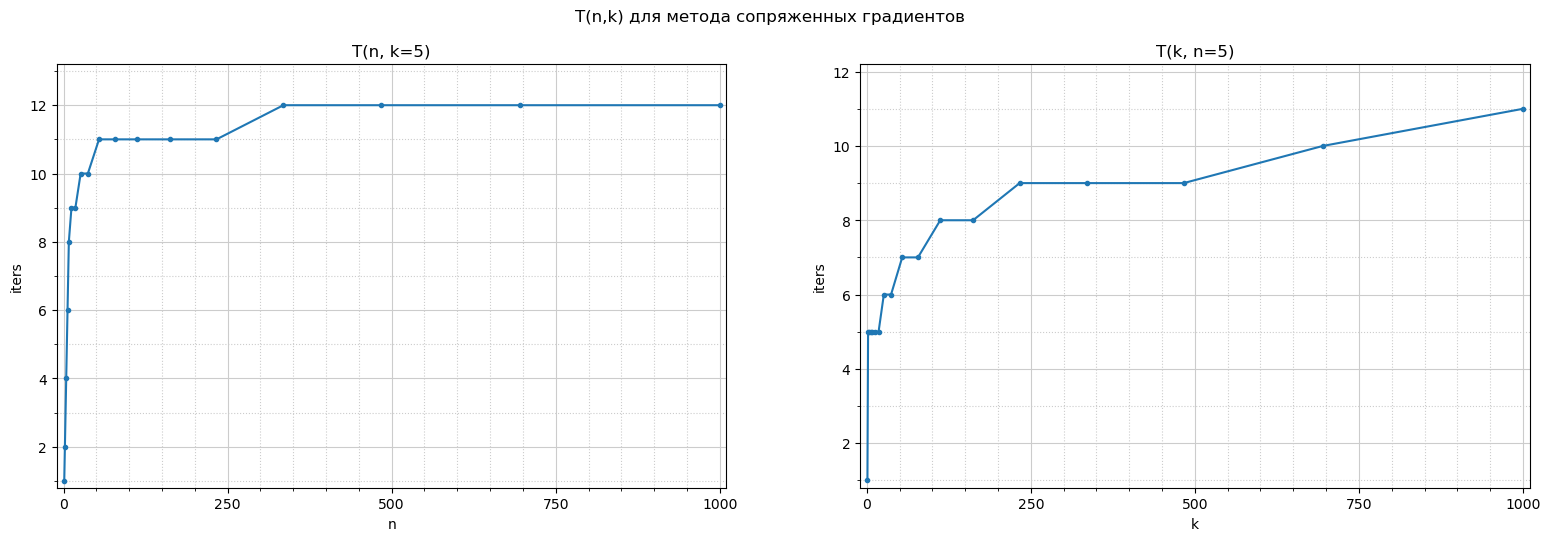

In [356]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(19, 5.5))
fig.suptitle('T(n,k) для метода сопряженных градиентов')

ax.set_ylim(0.8, res_n.max() + 1.2)
ax.set_xlim(-10, 1010)
ax.set_xlabel('n')
ax.set_ylabel('iters')
ax.set_title('T(n, k=5)')
create_grid(ax)

ax1.set_ylim(0.8, res_k.max() + 1.2)
ax1.set_xlim(-10, 1010)
ax1.set_xlabel('k')
ax1.set_ylabel('iters')
ax1.set_title('T(k, n=5)')
create_grid(ax1)

ax.plot(x_nk, res_n, marker='.')
ax1.plot(y_nk, res_k, marker='.')

plt.show()


### Зависимость $T$ от обоих параметров $n, k$


In [60]:
def t_all(n, k, method):
    res = []
    for i in range(len(n)):
        f, g = f_gen(n[i], k[i])
        x_0 = stats.uniform.rvs(size=n[i])
        res.append(method(f, g, x_0, 0.001, 0.001, 1000)[1])
    return np.array(res)

In [139]:
xp = yp = np.unique(np.geomspace(1, 1000, num=20, dtype=int))
n = len(xp)
xp1 = np.repeat(xp, n)
yp1 = np.tile(yp, n)
zp1 = t_all(xp1, yp1, conjugate_gradient)
x = np.reshape(xp1, (n, n))
y = np.reshape(yp1, (n, n))
z = np.reshape(zp1, (n, n))

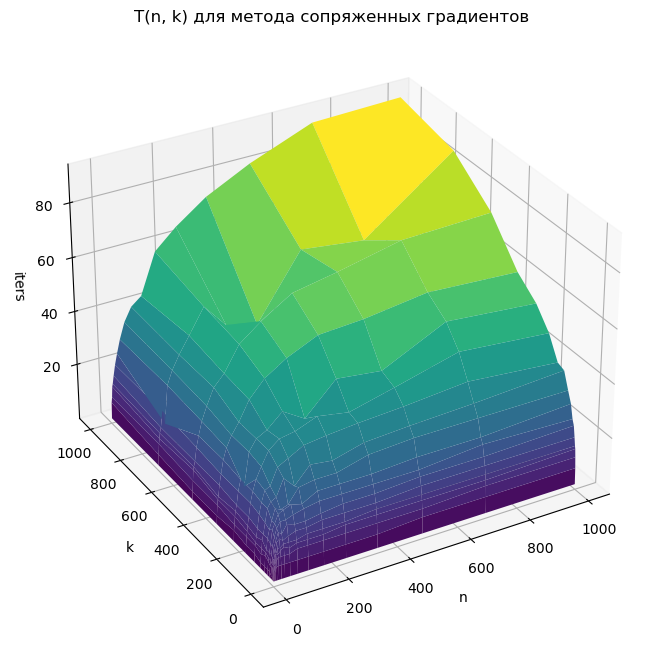

In [357]:
ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')
ax.plot_surface(x, y, z, cmap=plt.cm.viridis, antialiased=True)
ax.set_title('T(n, k) для метода сопряженных градиентов')
ax.set_xlabel('n')
ax.set_ylabel('k')
ax.set_zlabel('iters')
ax.view_init(30, -120)

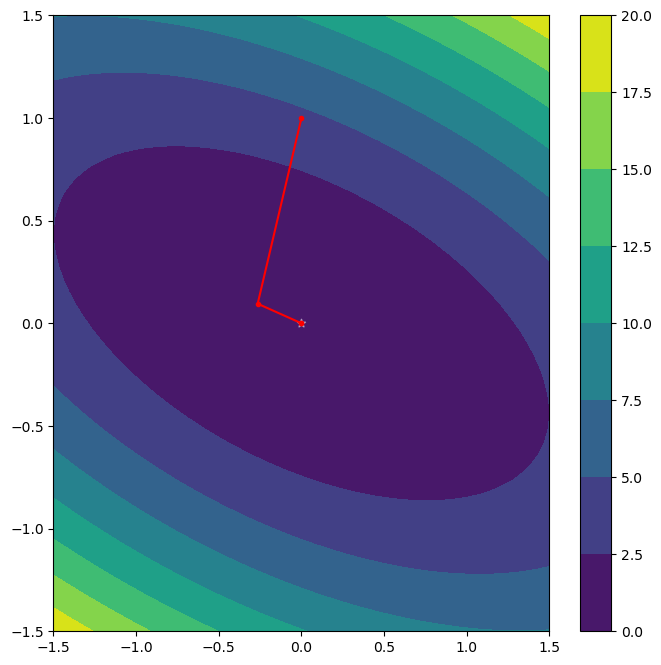

In [375]:
f2, grad_f = f_gen(2, 5)
ar = conjugate_gradient(f2, grad_f, np.array([0, 1]), 0.0001, 0.0001, 10000)[2]
m = np.array(ar.x.values.tolist())
arr1, arr2 = np.split(m, 2, axis=1)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
x2 = y2 = np.linspace(-1.5, 1.5)
x2 = np.repeat(x2, 50)
y2 = np.tile(y2, 50)
z2 = []
for i in range(2500):
    z2.append(f2(np.array([x2[i], y2[i]])))
x2 = np.reshape(x2, (50, 50))
y2 = np.reshape(y2, (50, 50))
z2 = np.reshape(z2, (50, 50))

cp = ax.contourf(x2, y2, z2)
fig.colorbar(cp)
ax.plot(arr1, arr2, color='red', marker='.')
ax.scatter(0, 0, color='white', marker='*', alpha=0.5)

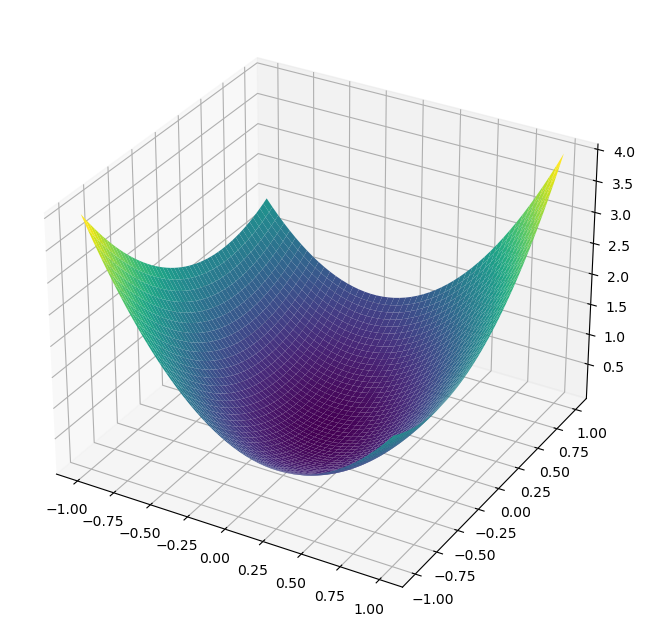

In [370]:
x2, y2, z2 = setup_3d_data(f_1, 50)
ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')
ax.plot_surface(x2, y2, z2, cmap=plt.cm.viridis, antialiased=True)

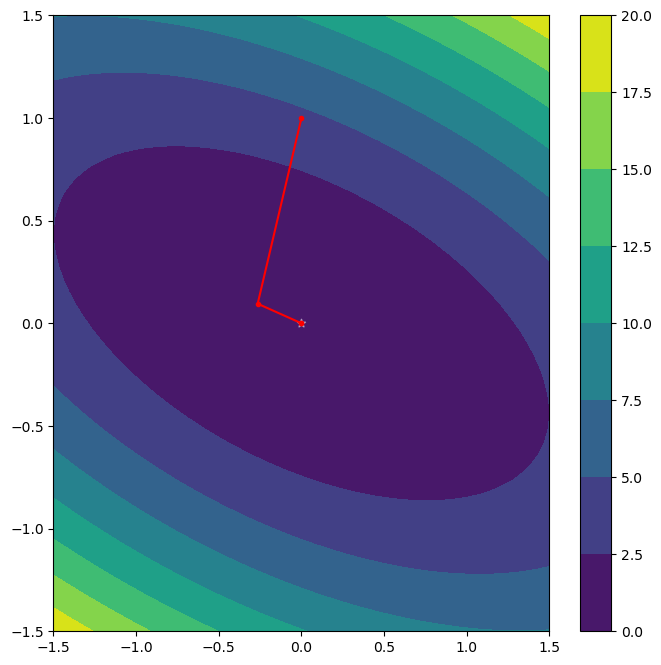

In [376]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
x2, y2, z2 = setup_3d_data(f2, 50)
cp = ax.contourf(x2, y2, z2)
fig.colorbar(cp)
ax.plot(arr1, arr2, color='red', marker='.')
ax.scatter(0, 0, color='white', marker='*', alpha=0.5)